In [ ]:
import glob

from potoo.plot import *
from potoo.util import *
import sklearn

from cache import *
from constants import *
from datasets import *
from features import *
from load import *
from sp14.model import *
from util import *
from viz import *

figsize('inline_short');

In [ ]:
recs_paths = load_recs_paths([
    'peterson-field-guide',
    'recordings',
])
display(
    df_summary(recs_paths),
    recs_paths[:5],
)

,dataset,path
dtype,object,object
sizeof,46.7 KiB,72.2 KiB
len,633,633
count,633,633
nunique,2,633
mean,NaN,NaN
std,NaN,NaN
min,peterson-field-guide,peterson-field-guide/amecro/audio/43215281 Caw (clear).mp3
25%,peterson-field-guide,peterson-field-guide/canwre/audio/43219271 Male Song (unusual).mp3
50%,peterson-field-guide,peterson-field-guide/marwre/audio/44412311 Chit.mp3


,dataset,path
0,recordings,recordings/081845.wav
1,recordings,"recordings/ACWO,NOFL,SPTO spotted towhee, acorn woodpecker, flicker.wav"
2,recordings,recordings/BEWR Bewicks Wren (Coyote Hills parking lot).wav
3,recordings,recordings/BEWR Bewicks Wren 2 (Coyote Hills parking lot) 2.wav
4,recordings,recordings/BEWR Bewicks Wren 2 (Coyote Hills parking lot).wav


In [ ]:
recs = load_recs_data(recs_paths)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[                                                                                          ] | 0% Completed |  0.3s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.7s

[##                                                                                        ] | 2% Completed |  0.8s

[##                                                                                        ] | 2% Completed |  0.9s

[##                                                                                        ] | 2% Completed |  1.0s

[##                                                                                        ] | 2% Completed |  1.2s

[##                                                                                        ] | 2% Completed |  1.3s

[##                                                                                        ] | 3% Completed |  1.4s

[##                                                                                        ] | 3% Completed |  1.5s

[####                                                                                      ] | 4% Completed |  1.6s

[####                                                                                      ] | 4% Completed |  1.8s

[####                                                                                      ] | 5% Completed |  1.9s

[####                                                                                      ] | 5% Completed |  2.1s

[####                                                                                      ] | 5% Completed |  2.2s

[#####                                                                                     ] | 6% Completed |  2.3s

[######                                                                                    ] | 6% Completed |  2.4s

[######                                                                                    ] | 7% Completed |  2.5s

[######                                                                                    ] | 7% Completed |  2.7s

[######                                                                                    ] | 7% Completed |  2.8s

[#######                                                                                   ] | 7% Completed |  2.9s

[#######                                                                                   ] | 7% Completed |  3.0s

[#######                                                                                   ] | 8% Completed |  3.1s

[#######                                                                                   ] | 8% Completed |  3.3s

[#######                                                                                   ] | 8% Completed |  3.4s

[#######                                                                                   ] | 8% Completed |  3.6s

[#######                                                                                   ] | 8% Completed |  3.7s

[########                                                                                  ] | 9% Completed |  3.8s

[########                                                                                  ] | 9% Completed |  4.0s

[#########                                                                                 ] | 10% Completed |  4.1s

[#########                                                                                 ] | 10% Completed |  4.2s

[#########                                                                                 ] | 10% Completed |  4.4s

[#########                                                                                 ] | 10% Completed |  4.5s

[#########                                                                                 ] | 11% Completed |  4.6s

[#########                                                                                 ] | 11% Completed |  4.8s

[##########                                                                                ] | 11% Completed |  4.9s

[##########                                                                                ] | 11% Completed |  5.0s

[##########                                                                                ] | 11% Completed |  5.1s

[##########                                                                                ] | 12% Completed |  5.2s

[###########                                                                               ] | 12% Completed |  5.3s

[############                                                                              ] | 13% Completed |  5.4s

[############                                                                              ] | 13% Completed |  5.6s

[#############                                                                             ] | 14% Completed |  5.7s

[#############                                                                             ] | 15% Completed |  5.9s

[##############                                                                            ] | 15% Completed |  6.0s

[##############                                                                            ] | 16% Completed |  6.1s

[###############                                                                           ] | 16% Completed |  6.2s

[###############                                                                           ] | 17% Completed |  6.4s

[#################                                                                         ] | 19% Completed |  6.5s

[###################                                                                       ] | 22% Completed |  6.6s

[#####################                                                                     ] | 24% Completed |  6.7s

[#######################                                                                   ] | 25% Completed |  6.8s

[#########################                                                                 ] | 27% Completed |  6.9s

[###########################                                                               ] | 30% Completed |  7.0s

[#############################                                                             ] | 32% Completed |  7.1s

[###############################                                                           ] | 34% Completed |  7.2s

[##################################                                                        ] | 37% Completed |  7.3s

[####################################                                                      ] | 40% Completed |  7.4s

[######################################                                                    ] | 43% Completed |  7.5s

[########################################                                                  ] | 45% Completed |  7.7s

[###########################################                                               ] | 48% Completed |  7.8s

[#############################################                                             ] | 50% Completed |  7.9s

[##############################################                                            ] | 51% Completed |  8.0s

[################################################                                          ] | 53% Completed |  8.1s

[##################################################                                        ] | 56% Completed |  8.2s

[####################################################                                      ] | 57% Completed |  8.3s

[######################################################                                    ] | 60% Completed |  8.4s

[########################################################                                  ] | 62% Completed |  8.5s

[##########################################################                                ] | 64% Completed |  8.6s

[###########################################################                               ] | 66% Completed |  8.7s

[##############################################################                            ] | 68% Completed |  8.8s

[###############################################################                           ] | 70% Completed |  8.9s

[#################################################################                         ] | 72% Completed |  9.0s

[###################################################################                       ] | 75% Completed |  9.2s

[#####################################################################                     ] | 76% Completed |  9.3s

[######################################################################                    ] | 78% Completed |  9.4s

[########################################################################                  ] | 80% Completed |  9.5s

[##########################################################################                ] | 82% Completed |  9.6s

[############################################################################              ] | 84% Completed |  9.7s

[##############################################################################            ] | 87% Completed |  9.8s

[###############################################################################           ] | 88% Completed | 10.0s

[#################################################################################         ] | 90% Completed | 10.1s

[####################################################################################      ] | 94% Completed | 10.2s

[#####################################################################################     ] | 95% Completed | 10.3s

[#######################################################################################   ] | 97% Completed | 10.4s

[##########################################################################################] | 100% Completed | 10.5s

In [ ]:
display(
    df_summary(recs),
    recs[:5],
)

,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
dtype,object,category,category,category,object,object,object,float64,float64,int64,object
sizeof,51.6 KiB,42.7 KiB,53.2 KiB,48.9 KiB,43.8 KiB,55.7 KiB,74.6 KiB,24.8 KiB,24.8 KiB,27.2 KiB,29.7 KiB
len,633,633,633,633,633,633,633,633,633,633,633
count,633,633,633,633,633,633,633,633,633,633,633
nunique,2.0,55.0,55.0,55.0,64.0,633.0,633.0,537.0,537.0,537.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.841,1.213,635941.850,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.301,1.358,712235.547,NaN
min,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,BEWR,081845,peterson-field-guide/amecro/audio/43215281 Caw (clear),2.74,0.115,60480,NaN
25%,peterson-field-guide,TUTI,Tufted Titmouse - TUTI,Tufted Titmouse,bewwre,43217721 Chick-a-dee Call,peterson-field-guide/canwre/audio/43219271 Male Song (unusual),15.50,0.650,340992,NaN
50%,peterson-field-guide,WIWR,Winter Wren - WIWR,Winter Wren,comrav,43219841 Churt,peterson-field-guide/marwre/audio/44412311 Chit,21.40,0.901,472320,NaN


,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
479,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186591 Kuk-curr Series,peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series,12.30,0.517,271296,"peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.304s long"
485,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186661 Chip-seer,peterson-field-guide/scaqua/audio/43186661 Chip-seer,12.10,0.509,266688,"peterson-field-guide/scaqua/audio/43186661 Chip-seer: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.095s long"
486,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186671 Kuk,peterson-field-guide/scaqua/audio/43186671 Kuk,15.60,0.657,344448,"peterson-field-guide/scaqua/audio/43186671 Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 15.621s long"
487,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186681 Wing sounds & Kuk,peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk,7.73,0.325,170496,"peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 7.732s long"
482,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186621 Zreek Series,peterson-field-guide/scaqua/audio/43186621 Zreek Series,10.10,0.423,221760,"peterson-field-guide/scaqua/audio/43186621 Zreek Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.057s long"


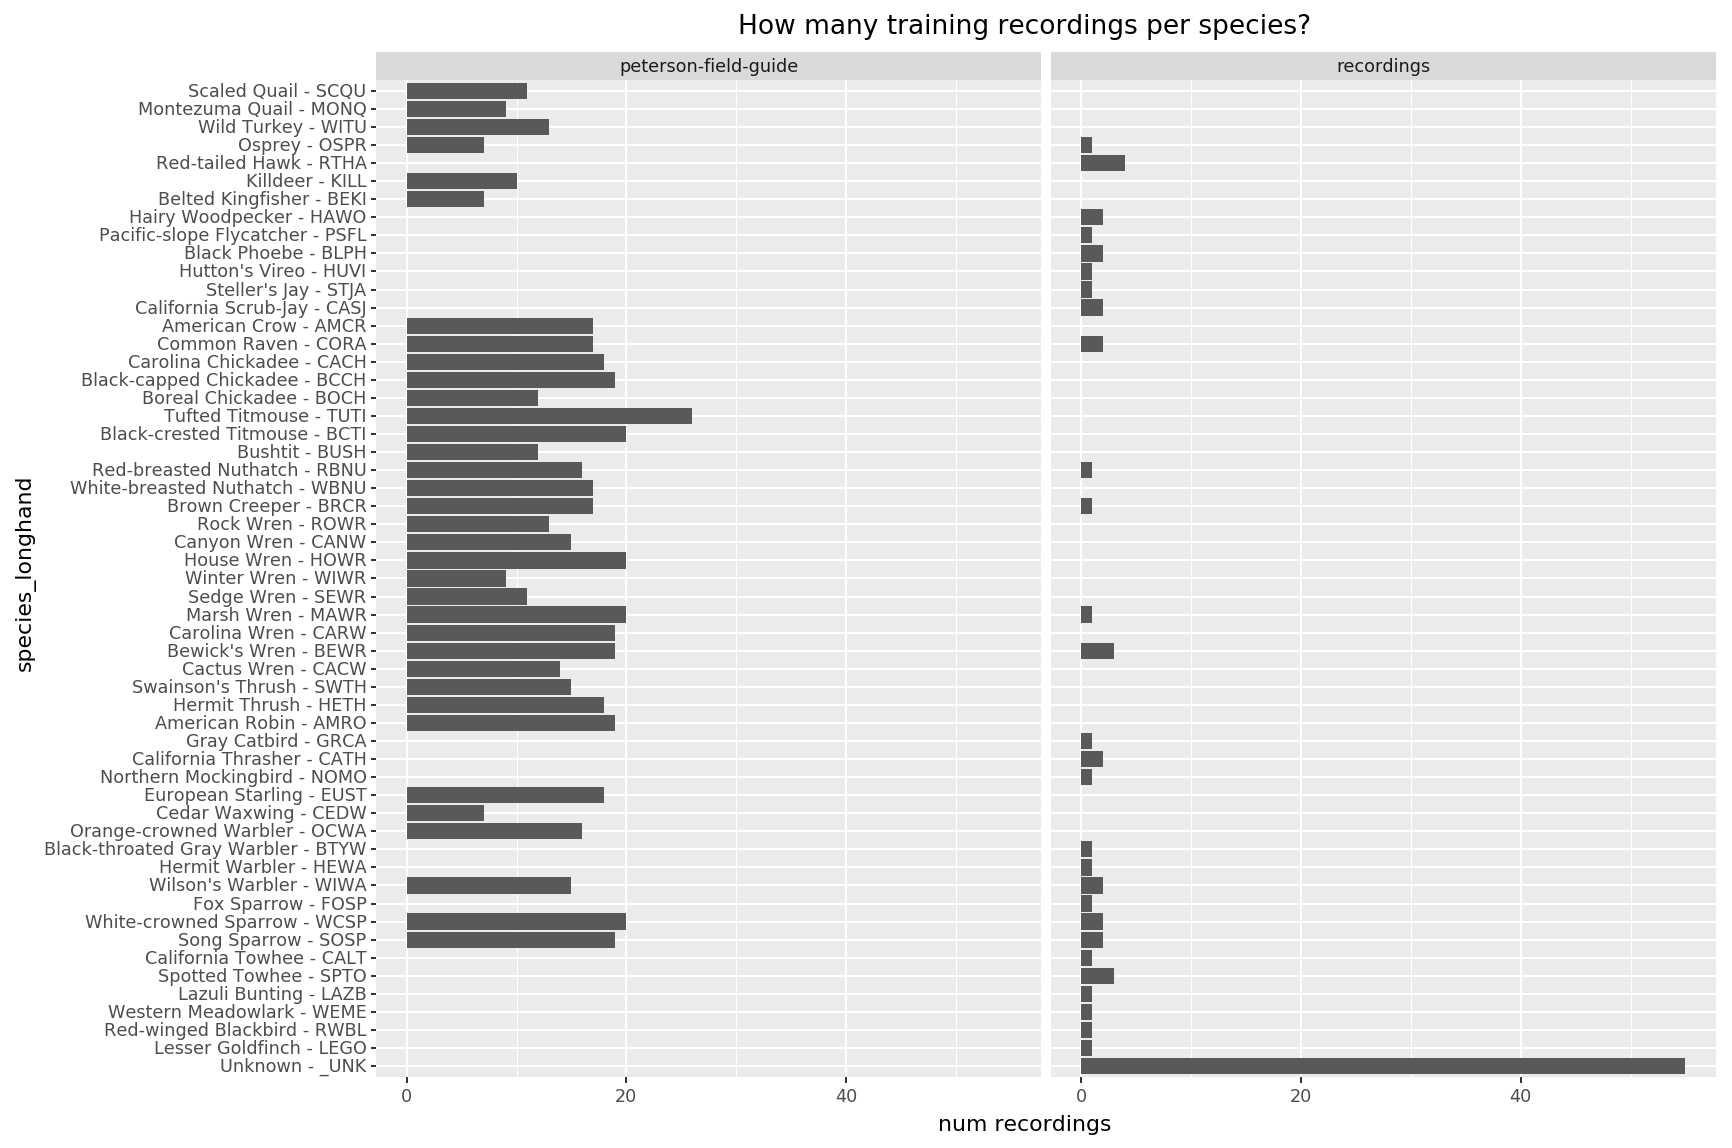

<ggplot: (317995370)>

In [ ]:
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .pipe(ggplot, aes(x='species_longhand'))
    + geom_bar()
    + coord_flip()
    + facet_grid('. ~ dataset')
    + ylab('num recordings')
    + theme_figsize(aspect_ratio=1.5/1)
    + ggtitle('How many training recordings per species?')
)

In [ ]:
# Stats
(recs
    .assign(
        n=1,
        duration_h=lambda df: df.duration_s / 3600,
        samples_gb=lambda df: df.samples_mb / 1024,
        species=lambda df: df.species.cat.remove_unused_categories(),  # Else groupby includes all categories
    )
    .groupby([
        'dataset',
        'species',
    ])
    [['n', 'duration_h', 'samples_gb', 'samples_n']]
    .sum()
    .dropna()
)

n  duration_h  samples_gb  samples_n
dataset              species                                         
peterson-field-guide SCQU     11.0       0.052   7.749e-03  4.160e+06
                     MONQ      9.0       0.052   7.715e-03  4.142e+06
                     WITU     13.0       0.087   1.289e-02  6.920e+06
                     OSPR      7.0       0.038   5.593e-03  3.003e+06
                     KILL     10.0       0.052   7.715e-03  4.142e+06
                     BEKI      7.0       0.036   5.353e-03  2.874e+06
                     AMCR     17.0       0.103   1.526e-02  8.194e+06
                     CORA     17.0       0.107   1.581e-02  8.486e+06
                     CACH     18.0       0.092   1.366e-02  7.336e+06
                     BCCH     19.0       0.082   1.215e-02  6.526e+06
                     BOCH     12.0       0.065   9.655e-03  5.183e+06
                     TUTI     26.0       0.144   2.124e-02  1.140e+07
                     BCTI     20.0       0.119   1.765e-02  9.476e+06
                     BUSH     12.0       0.050   7.447e-03  3.998e+06
                     RBNU     16.0       0.102   1.508e-02  8.095e+06
                     WBNU     17.0       0.082   1.213e-02  6.513e+06
                     BRCR     17.0       0.083   1.226e-02  6.583e+06
                     ROWR     13.0       0.086   1.264e-02  6.788e+06
                     CANW     15.0       0.068   1.011e-02  5.428e+06
                     HOWR     20.0       0.126   1.866e-02  1.002e+07
                     WIWR      9.0       0.091   1.342e-02  7.205e+06
                     SEWR     11.0       0.079   1.169e-02  6.275e+06
                     MAWR     20.0       0.141   2.087e-02  1.120e+07
                     CARW     19.0       0.098   1.447e-02  7.767e+06
                     BEWR     19.0       0.114   1.688e-02  9.060e+06
                     CACW     14.0       0.068   1.000e-02  5.369e+06
                     SWTH     15.0       0.091   1.349e-02  7.240e+06
                     HETH     18.0       0.119   1.756e-02  9.430e+06
                     AMRO     19.0       0.103   1.527e-02  8.199e+06
                     EUST     18.0       0.115   1.704e-02  9.147e+06
                     CEDW      7.0       0.036   5.373e-03  2.885e+06
                     OCWA     16.0       0.096   1.417e-02  7.610e+06
                     WIWA     15.0       0.092   1.358e-02  7.293e+06
                     WCSP     20.0       0.089   1.311e-02  7.036e+06
                     SOSP     19.0       0.094   1.389e-02  7.460e+06
recordings           OSPR      1.0       0.025   3.682e-03  1.977e+06
                     RTHA      4.0       0.047   6.977e-03  3.746e+06
                     HAWO      2.0       0.032   4.754e-03  2.552e+06
                     PSFL      1.0       0.015   2.209e-03  1.186e+06
                     BLPH      2.0       0.032   4.771e-03  2.561e+06
                     HUVI      1.0       0.024   3.622e-03  1.944e+06
                     STJA      1.0       0.019   2.822e-03  1.515e+06
                     CASJ      2.0       0.070   1.029e-02  5.525e+06
                     CORA      2.0       0.029   4.257e-03  2.285e+06
                     RBNU      1.0       0.037   5.508e-03  2.957e+06
                     BRCR      1.0       0.009   1.282e-03  6.884e+05
                     MAWR      1.0       0.006   9.482e-04  5.091e+05
                     BEWR      3.0       0.030   4.400e-03  2.362e+06
                     GRCA      1.0       0.019   2.819e-03  1.514e+06
                     CATH      2.0       0.034   5.026e-03  2.698e+06
                     NOMO      1.0       0.017   2.544e-03  1.366e+06
                     BTYW      1.0       0.017   2.443e-03  1.312e+06
                     HEWA      1.0       0.097   1.435e-02  7.703e+06
                     WIWA      2.0       0.022   3.217e-03  1.727e+06
                     FOSP      1.0       0.032   4.674e-03  2.509e+06
                     WCSP      2.0       0.

In [ ]:
display(
    df_summary(recs),
    recs[:10],
    (recs
        .assign(n=1)
        .groupby(['dataset', 'species'])
        ['n'].sum()
    ),
)

,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
dtype,object,category,category,category,object,object,object,float64,float64,int64,object
sizeof,53.7 KiB,42.9 KiB,107.5 KiB,49.4 KiB,43.9 KiB,56.2 KiB,75.7 KiB,24.8 KiB,24.8 KiB,27.2 KiB,29.7 KiB
len,633,633,633,633,633,633,633,633,633,633,633
count,633,633,633,633,633,633,633,633,633,633,633
nunique,2.0,55.0,55.0,55.0,64.0,633.0,633.0,537.0,537.0,537.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.841,1.213,635941.850,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.301,1.358,712235.547,NaN
min,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,BEWR,081845,peterson-field-guide/amecro/audio/43215281 Caw (clear),2.74,0.115,60480,NaN
25%,peterson-field-guide,TUTI,Tufted Titmouse - TUTI,Tufted Titmouse,bewwre,43217721 Chick-a-dee Call,peterson-field-guide/canwre/audio/43219271 Male Song (unusual),15.50,0.650,340992,NaN
50%,peterson-field-guide,WIWR,Winter Wren - WIWR,Winter Wren,comrav,43219841 Churt,peterson-field-guide/marwre/audio/44412311 Chit,21.40,0.901,472320,NaN


,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
479,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186591 Kuk-curr Series,peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series,12.30,0.517,271296,"peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.304s long"
485,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186661 Chip-seer,peterson-field-guide/scaqua/audio/43186661 Chip-seer,12.10,0.509,266688,"peterson-field-guide/scaqua/audio/43186661 Chip-seer: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.095s long"
486,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186671 Kuk,peterson-field-guide/scaqua/audio/43186671 Kuk,15.60,0.657,344448,"peterson-field-guide/scaqua/audio/43186671 Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 15.621s long"
487,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186681 Wing sounds & Kuk,peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk,7.73,0.325,170496,"peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 7.732s long"
482,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186621 Zreek Series,peterson-field-guide/scaqua/audio/43186621 Zreek Series,10.10,0.423,221760,"peterson-field-guide/scaqua/audio/43186621 Zreek Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.057s long"
481,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186611 Kuk-curr Series,peterson-field-guide/scaqua/audio/43186611 Kuk-curr Series,27.90,1.170,614592,"peterson-field-guide/scaqua/audio/43186611 Kuk-curr Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 27.873s long"
480,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186601 Kuk-curr Series,peterson-field-guide/scaqua/audio/43186601 Kuk-curr Series,19.70,0.831,435456,"peterson-field-guide/scaqua/audio/43186601 Kuk-curr Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 19.749s long"
484,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186641 Chip-seer,peterson-field-guide/scaqua/audio/43186641 Chip-seer,22.30,0.939,492480,"peterson-field-guide/scaqua/audio/43186641 Chip-seer: 1 channels, 16 bit, sampled @ 22.05 kHz, 22.335s long"
483,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186631 Zreek Series,peterson-field-guide/scaqua/audio/43186631 Zreek Series,7.86,0.331,173376,"peterson-field-guide/scaqua/audio/43186631 Zreek Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 7.863s long"
477,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186571 Song (Screech),peterson-field-guide/scaqua/audio/43186571 Song (Screech),32.20,1.350,710208,"peterson-field-guide/scaqua/audio/43186571 Song (Screech): 1 channels, 16 bit, sampled @ 22.05 kHz, 32.209s long"


dataset               species
peterson-field-guide  SCQU       11
                      MONQ        9
                      WITU       13
                      OSPR        7
                      KILL       10
                      BEKI        7
                      AMCR       17
                      CORA       17
                      CACH       18
                      BCCH       19
                      BOCH       12
                      TUTI       26
                      BCTI       20
                      BUSH       12
                      RBNU       16
                      WBNU       17
                      BRCR       17
                      ROWR       13
                      CANW       15
                      HOWR       20
                      WIWR        9
                      SEWR       11
                      MAWR       20
                      CARW       19
                      BEWR       19
                      CACW       14
                      SWTH       15
                      HETH       18
                      AMRO       19
                      EUST       18
                      CEDW        7
                      OCWA       16
                      WIWA       15
                      WCSP       20
                      SOSP       19
recordings            OSPR        1
                      RTHA        4
                      HAWO        2
                      PSFL        1
                      BLPH        2
                      HUVI        1
                      STJA        1
                      CASJ        2
                      CORA        2
                      RBNU        1
                      BRCR        1
                      MAWR        1
                      BEWR        3
                      GRCA        1
                      CATH        2
                      NOMO        1
                      BTYW        1
                      HEWA        1
                      WIWA        2
                      FOSP        1
                      WCSP        2
                      SOSP        2
                      CALT        1
                      SPTO        3
                      LAZB        1
                      WEME        1
                      RWBL        1
                      LEGO        1
                      _UNK       55
Name: n, dtype: int64

In [ ]:
# Compute spectros
#   - TODO Avoid recomputing spectros again below, in model.fit_proj
spectro_model = Model(verbose_config=False)
display(len(recs))
recs['spectro'] = spectro_model.spectros(recs)

In [ ]:
with with_figsize(width=25/2, height=212/2):
    plot_many_spectros(t_max=30, recs=(recs
        [lambda df: df.dataset == 'peterson-field-guide']
        [-50:]  # Avoid heavy plot
    ))

In [ ]:
# TODO Split models

# Data
recs = ...

# Basic features
features = Features()
recs['spectro'] = features.spectros(recs)
recs['patches'] = features.patches(recs)

# Fit projection, add learned features
train_projection_n = 10
_shuf = sklearn.utils.shuffle(recs, random_state=0)
recs_train_projection = _shuf[:train_projection_n]
projection = Projection()
projection.fit(recs_train_projection)
recs['feat'] = projection.transform(recs)

# Fit search
train_n, test_n = 5, 5
_shuf = sklearn.utils.shuffle(recs, random_state=0)
recs_train, recs_test = _shuf[:train_n], _shuf[train_n : train_n + test_n]
search = Search()
search.fit(recs_train)

# Predict
search.predict(recs_test, 'classes')
search.predict(recs_test, 'kneighbors')

# Eval search
search.confusion_matrix(recs_test)
search.coverage_errors(recs_test)

In [ ]:
%%time
# Load projection from cache (from fit_features.ipynb)
from sp14.model import *
# k, n = 50,  60   # Faster dev
k, n = 500, 300  # Mem safe (~17m uncached for 6 configs)
# k, n = 500, 535  # Full [XXX Not mem safe] [len(peterson) is currently 535]
config = Dict(n=n, proj_skm_config=dict(k=k, normalize=False, standardize=False, pca_whiten=True, do_pca=True))
recs_train_projection = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    .pipe(sklearn.utils.shuffle, random_state=0)  # XXX
    .sample(config.n, random_state=0)
)
projection = Projection(verbose_config=False, proj_skm_config=config.proj_skm_config)
projection.fit_proj(recs_train_projection)

[19:15:41.461] patches:recs
  len(recs): 300
  duration_s: [30.85061224489796, 21.995102040816327, 39.627755102040815, 26.33142857142857, 24.920816326530613, 30.693877551020407, 35.68326530612245, 25.991836734693877, 7.444897959183673, 4.022857142857143, 20.45387755102041, 21.91673469387755, 16.90122448979592, 16.744489795918366, 14.863673469387756, 21.577142857142857, 15.777959183673469, 18.546938775510203, 8.881632653061224, 38.26938775510204, 20.74122448979592, 15.307755102040817, 14.550204081632653, 8.594285714285714, 10.736326530612246, 49.136326530612244, 24.60734693877551, 17.50204081632653, 8.124081632653061, 16.79673469387755, 20.271020408163267, 25.103673469387754, 13.035102040816327, 13.688163265306123, 30.27591836734694, 19.33061224489796, 14.236734693877551, 13.949387755102041, 23.875918367346937, 20.035918367346937, 20.715102040816326, 35.735510204081635, 21.524897959183672, 33.671836734693876, 25.835102040816327, 31.42530612244898, 22.386938775510203, 20.845714285714287,

________________________________________________________________________________
[Memory] Calling sp14.model._patches_from_recs...
_patches_from_recs(<class '__main__.Projection'>, [ Recording(dataset='peterson-field-guide', species='BEKI', species_longhand='Belted Kingfisher - BEKI', species_com_name='Belted Kingfisher', species_query='belkin1', basename='43205241 Low Rattle & High Rattle', name='peterson-field-guide/belkin1/audio/43205241 Low Rattle & High Rattle', duration_s=30.85061224489796, samples_mb=1.2974853515625, samples_n=680256, audio=peterson-field-guide/belkin1/audio/43205241 Low Rattle & High Rattle: 1 channels, 16 bit, sampled @ 22.05 kHz, 30.851s long),
  Recording(dataset='peterson-field-guide', species='BCCH', species_longhand='Black-capped Chickadee - BCCH', species_com_name='Black-capped Chickadee', species_query='bkcchi', basename='43217251 Whist..., 
{ 'f_bins': 40,
  'f_min': 1000,
  'frame_length': 512,
  'frame_window': 'hann',
  'hop_length': 256,
  'sample_

________________________________________________________________________________
[Memory] Calling sp14.model._spectros_cache_block...
_spectros_cache_block(<class '__main__.Projection'>, [ peterson-field-guide/amecro/audio/43215311 Caw (harsh): 1 channels, 16 bit, sampled @ 22.05 kHz, 15.464s long,
  peterson-field-guide/amecro/audio/43215321 Caw (harsh): 1 channels, 16 bit, sampled @ 22.05 kHz, 17.711s long,
  peterson-field-guide/amecro/audio/43215331 Caw (presumed female from nest): 1 channels, 16 bit, sampled @ 22.05 kHz, 16.980s long,
  peterson-field-guide/amecro/audio/43215341 Caw (presumed female from nest): 1 channels, 16 bit, sampled @ 22.05 kHz, 23.092s long,
  peterson-field-guide/amecro/audio/43215351 Caw (harsh) & Rasp: 1 channels, 16 bit, sampled @ 22.05 kHz, 30.694s long,
  peterson-field-guide/amecro/audio/43215361 Rasp & Caw (harsh): 1 channels, 16 bit, sam..., sample_rate=22050, f_min=1000, f_bins=40, hop_length=256, frame_length=512, frame_window='hann', __cache_ver

Persisting in /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_spectros_cache_block/b352ea0b94fb361af505f71d1062d2b1


/Users/danb/hack/bubo/features/cache.py:93: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return cache_func(*args, **kwargs)


____________________________________________spectros_cache_block - 13.7s, 0.2min
[19:15:57.886] patches:spectros
  (f, t): [[40, 2656], [40, 1893], [40, 3412], [40, 2267], [40, 2145], [40, 2642], [40, 3072], [40, 2237], [40, 640], [40, 345], [40, 1760], [40, 1886], [40, 1454], [40, 1441], [40, 1279], [40, 1857], [40, 1358], [40, 1596], [40, 764], [40, 3295], [40, 1785], [40, 1317], [40, 1252], [40, 739], [40, 923], [40, 4231], [40, 2118], [40, 1506], [40, 698], [40, 1445], [40, 1745], [40, 2161], [40, 1121], [40, 1178], [40, 2606], [40, 1664], [40, 1225], [40, 1200], [40, 2055], [40, 1724], [40, 1783], [40, 3077], [40, 1853], [40, 2899], [40, 2224], [40, 2705], [40, 1927], [40, 1794], [40, 3119], [40, 1387], [40, 1418], [40, 674], [40, 4415], [40, 2665], [40, 1580], [40, 305], [40, 1265], [40, 1378], [40, 5502], [40, 521], [40, 2145], [40, 2834], [40, 1880], [40, 1187], [40, 2399], [40, 1837], [40, 914], [40, 3365], [40, 1740], [40, 572], [40, 494], [40, 1182], [40, 1823], [40, 1450], 

________________________________________________________________________________
[Memory] Calling sp14.model._patches_from_spectros...
_patches_from_spectros(<class '__main__.Projection'>, [ <features.Melspectro object at 0x12f425c18>,
  <features.Melspectro object at 0x158a109..., 
4, __cache_version=0)


Persisting in /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_spectros/894b466c9a9aaa4408107f4ae2b13d46


/Users/danb/hack/bubo/features/cache.py:93: UserWarning: Persisting input arguments took 2.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return cache_func(*args, **kwargs)


____________________________________________patches_from_spectros - 5.5s, 0.1min
Persisting in /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_recs/e97df35b27b1502102a8fe80fe3e3c8a


/Users/danb/hack/bubo/features/cache.py:93: UserWarning: Persisting input arguments took 0.68s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return cache_func(*args, **kwargs)


_______________________________________________patches_from_recs - 27.4s, 0.5min
[19:16:10.251] patches:patches
  (f*p, t): [[160, 2653], [160, 1890], [160, 3409], [160, 2264], [160, 2142], [160, 2639], [160, 3069], [160, 2234], [160, 637], [160, 342], [160, 1757], [160, 1883], [160, 1451], [160, 1438], [160, 1276], [160, 1854], [160, 1355], [160, 1593], [160, 761], [160, 3292], [160, 1782], [160, 1314], [160, 1249], [160, 736], [160, 920], [160, 4228], [160, 2115], [160, 1503], [160, 695], [160, 1442], [160, 1742], [160, 2158], [160, 1118], [160, 1175], [160, 2603], [160, 1661], [160, 1222], [160, 1197], [160, 2052], [160, 1721], [160, 1780], [160, 3074], [160, 1850], [160, 2896], [160, 2221], [160, 2702], [160, 1924], [160, 1791], [160, 3116], [160, 1384], [160, 1415], [160, 671], [160, 4412], [160, 2662], [160, 1577], [160, 302], [160, 1262], [160, 1375], [160, 5499], [160, 518], [160, 2142], [160, 2831], [160, 1877], [160, 1184], [160, 2396], [160, 1834], [160, 911], [160, 3362], [

[19:16:10.629] fit_proj:skm_X
  skm_X.shape: [160, 531092]


________________________________________________________________________________
[Memory] Calling sp14.model._skm_fit...
_skm_fit(<class '__main__.Projection'>, <sp14.skm.SKM object at 0x1169de400>, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), __cache_version=0)
[19:16:12.586] [SKM] fit
[19:16:12.586] [SKM] _pca_fit_transform


[19:16:26.879] [SKM] fit: iterating...


[19:16:35.015] [SKM] epoch[1] assignment_change[1.0]


[19:16:40.355] [SKM] epoch[2] assignment_change[0.6060174131788842]


[19:16:45.531] [SKM] epoch[3] assignment_change[0.45753466442725554]


[19:16:50.524] [SKM] epoch[4] assignment_change[0.28317504311870634]


[19:16:55.527] [SKM] epoch[5] assignment_change[0.18083872474072288]


[19:17:01.205] [SKM] epoch[6] assignment_change[0.12623613234618483]


[19:17:07.061] [SKM] epoch[7] assignment_change[0.09484609069615058]


[19:17:12.795] [SKM] epoch[8] assignment_change[0.07521295745369917]


[19:17:18.210] [SKM] epoch[9] assignment_change[0.06154677532329615]


[19:17:24.013] [SKM] epoch[10] assignment_change[0.05049972509471052]


[19:17:29.411] [SKM] epoch[11] assignment_change[0.04272894338457367]


[19:17:35.220] [SKM] epoch[12] assignment_change[0.037108448253786536]


[19:17:40.512] [SKM] epoch[13] assignment_change[0.03287942578686932]


[19:17:45.744] [SKM] epoch[14] assignment_change[0.028341605597523592]


[19:17:51.033] [SKM] epoch[15] assignment_change[0.025982315681652143]


[19:17:56.093] [SKM] epoch[16] assignment_change[0.02325774065510307]


[19:18:01.403] [SKM] epoch[17] assignment_change[0.0210340204710295]


[19:18:06.723] [SKM] epoch[18] assignment_change[0.01920571200469975]


[19:18:11.848] [SKM] epoch[19] assignment_change[0.017646660089024123]


[19:18:17.266] [SKM] epoch[20] assignment_change[0.016443478719317933]


[19:18:22.632] [SKM] epoch[21] assignment_change[0.0155415634202737]


[19:18:27.660] [SKM] epoch[22] assignment_change[0.015148034615471519]


[19:18:32.969] [SKM] epoch[23] assignment_change[0.0146716576412373]


[19:18:38.391] [SKM] epoch[24] assignment_change[0.014136910365812326]


[19:18:44.158] [SKM] epoch[25] assignment_change[0.013660533391578107]


[19:18:49.328] [SKM] epoch[26] assignment_change[0.013436466751523277]


[19:18:54.415] [SKM] epoch[27] assignment_change[0.012865944130207196]


[19:18:59.851] [SKM] epoch[28] assignment_change[0.011930136398213493]


[19:19:05.484] [SKM] epoch[29] assignment_change[0.01153660759341131]


[19:19:10.855] [SKM] epoch[30] assignment_change[0.011092240139184925]


[19:19:16.426] [SKM] epoch[31] assignment_change[0.010275055922514367]


[19:19:21.866] [SKM] epoch[32] assignment_change[0.009836337207112892]
[19:19:21.866] [SKM] fit: done: assignment_change[0.009836337207112892] < assignment_change_eps[0.01]
Persisting in /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_skm_fit/df8dee887aa0658424145c8e2637849a


/Users/danb/hack/bubo/features/cache.py:93: UserWarning: Persisting input arguments took 2.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return cache_func(*args, **kwargs)


________________________________________________________skm_fit - 190.4s, 3.2min
[19:19:24.903] fit_proj:skm.fit
  skm.pca.components_.shape: [106, 160]
  skm.D.shape: [106, 500]
CPU times: user 5min 53s, sys: 1min 51s, total: 7min 44s
Wall time: 3min 43s


In [ ]:
recs_train_search = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
)

In [ ]:
# TODO Fit Search

from sklearn.base import BaseEstimator
from sklearn.neighbors.classification import KNeighborsClassifier

def fit(self, recs):
    self.classifier_ = classifier_fit(recs, **self.config.classifier_config)

@cache(version=0)
def fit_classifier(projection: Model, recs, Classifier=KNeighborsClassifier, **classifier_config) -> BaseEstimator:
    classifier = Classifier(**classifier_config)
    recs_ = projection.to_X(recs)
    classes_ = projection.to_y(recs)
    patches_ = projection._patches(recs_, **projection.config.patch_config)
    feats_ = projection._feats(patches_, projection.proj_skm_, projection.config.agg_config)  # (skm.transform)
    return classifier.fit(
        # TODO np.array for X,y
        X=recs.audio,  # TODO model.feats(recs)
        y=recs.species,
    )

def species_probs(model, rec) -> List[Tuple['species', float]]:
    return model.predict_proba(rec.audio)

# TODO Show verbose progress during fit
classifer = fit_classifier(
    recs_train_search,
    cls=KNeighborsClassifier,
    # TODO knn config
)

In [ ]:
# TODO confusion_matrix

def confusion_matrix(model, recs) -> 'np.ndarray[count @ (n_species, n_species)]':
    species_preds = model.predict(recs.audio)
    return sklearn.metrics.confusion_matrix(recs.species, species_preds)

confusion_matrix(classifer, recs_train_search)

In [ ]:
# TODO coverage_errors

def coverage_errors(model, recs) -> List[('species', float)]:
    species_probs = model.predict_proba(recs.audio)

coverage_errors(classifier, recs_train_search)